# Siamese Network

Took inspiration from https://github.com/radekosmulski/whale/blob/master/siamese_network_prototype.ipynb
https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7

In [1]:
import fastai
from fastai import *
from fastai.vision import *
print(f'fastai version: {fastai.__version__}')
import torch
from torch import nn
print(f'torch version: {torch.__version__}')
torch.backends.cudnn.benchmark = True  # enable cudnn auto-tuner to find the best algorithm to use for your hardware.

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
# to stop fastai from printing out "UserWarning: Tensor is int32: upgrading to int64;"

verbose = True  # print out extra detail stuff

fastai version: 1.0.45
torch version: 1.0.0


In [2]:
# global setting
bs = 16
num_workers = 0
# num_workers = 0  # if using kaggle kernel or for fixing broken pipe error
sz = 224  # image size

data_fp = Path('data')
data_train = 'train'
data_test = 'test'
data_label = 'train.csv'
# crop_fp = data_fp/'cropping.txt'

procedure
* remove all new whales?
* add code that takes into account classes without single images
    * if classes with single image, return a data augmented version or different image
    * if new whale return a random image. 
    
    
 

# Looking at the Data

In [3]:
labels = pd.read_csv(data_fp/data_label)
print(labels.shape)
print(f'Number of classes: {len(labels.Id.unique()):,}')
labels.head()

(25361, 2)
Number of classes: 5,005


,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


## Whale class with only one image 

In [4]:
cls_count = labels.Id.value_counts()
cls_one = cls_count[cls_count == 1]
print(f'Number of classes with only one image: {len(cls_one):,}')
print(f'Single image accounts for: {len(cls_one)/len(cls_count):.0%}')
cls_one = cls_one.index.tolist()
cls_one[:5]

Number of classes with only one image: 2,073
Single image accounts for: 41%


['w_e8b2157', 'w_b67fcb9', 'w_ce59977', 'w_b1dbfd3', 'w_9f30885']

In [5]:
cls_count.head()  # most common class is new whale

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64

## New whale class

Remove images that are labeled as new whale because there is no point in classifying when they are all different. Test images will be labeled as new_whale when the model can not find anything close (threshold) to itself.

In [6]:
newwhale_idx = labels.index[labels.Id == 'new_whale'].tolist()
if verbose: print(len(newwhale_idx))

9664


## Train/Validation Split

Pre-determined train/validation split because of the usual situation of having classes with only one image. In addition, to be able to compare different model performance. Code for split is in first_attempt.ipynb section Stratified Split. 

New Whale is not removed from validation set because we need a represented sample that is as close to test data set as possible which has new whale sampe. Also from the validation, we can set the threshold for dissimilarity to be classfied as new_whale.

In [7]:
train_idx = pd.read_csv(data_fp/'train_idx.csv')['index'].tolist()
if verbose: print(train_idx[:5], f'length: {len(train_idx):,}')

[21280, 16349, 4289, 13468, 25308] length: 19,341


In [8]:
val_idx = list(set(labels.index.tolist()) - set(train_idx))
if verbose: print(val_idx[:5], f'length: {len(val_idx):,}')

[8, 9, 11, 16, 17] length: 6,020


In [9]:
# remove new_whale from train
train_idx = list(set(train_idx).difference(set(newwhale_idx)))
print(f'new train: {len(train_idx):,}, val: {len(val_idx):,}')

new train: 11,610, val: 6,020


# Create Data Bunch

In [10]:
tfms = get_transforms(do_flip=False, max_zoom=1)

In [11]:
# using fastai for importing and transforming of the data
src = (ImageItemList.from_df(df=labels, path=data_fp, cols='Image', folder=data_train)
                    .no_split()
                    .label_from_df(cols='Id')
                    .transform(tfms, size=sz, resize_method=ResizeMethod.SQUISH))
if verbose: print(src)

LabelLists;

Train: LabelList (25361 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
w_f48451c,w_c3d896a,w_20df2c5,new_whale,new_whale
Path: data;

Valid: LabelList (0 items)
x: ImageItemList

y: CategoryList

Path: data;

Test: None


In [12]:
# Manually split train and validation set
trn = src.train[train_idx]
val = src.train[val_idx]

In [13]:
class PairImgDataset(Dataset):
    def __init__(self, ds, ds_all, cls_one, p:float=0.5):
        """
        Args:
            ds (LabelList): a tuple containing a PIL Image and a Category class
            ds_all (LabelList): contains all the images in the train data set. 
            cls_one [string]: a list of classes with only one image sample
            p (float): probability of returning a same image class pair
        """
        self.ds = ds
        self.cls = ds.y.items  # class's int value
        self.ds_all = ds_all
        self.cls_all = ds_all.y.items
        self.cls_one = cls_one
        self.p = p
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        same_cls = np.random.choice([0,1], p=[1-self.p, self.p])  # have control over balancing the split
        return self.same_class(idx) if same_cls else self.diff_class(idx)
    
    def same_class(self, idx):
        img1 = self.ds[idx]  # image + class
        
        if  img1[1].obj in self.cls_one or img1[1].obj == 'new_whale':
            # new_whale and classes with single image are paired with its augmented self
            img2 = self.ds[idx][0]  # fastai return a new augmented image after each access
        else:
            idx2 = np.where(self.cls[idx] == self.cls_all)[0]  # idx of images with same class including itself
            np.random.shuffle(idx2)  # randomize idx
            img2 = self.ds_all[idx2[0]][0]
        return self.combine_img(img1[0], img2, 1)
    
    def diff_class(self, idx):
        img1 = self.ds[idx]
        idxs = self.cls.tolist()
        
        if img1[1].obj != 'new_whale' or img1[1].obj not in cls_one:
            # remove same class images from possible selection
            idxs = np.where(self.cls[idx] != self.cls_all)[0]
        
        np.random.shuffle(idxs)
        img2 = self.ds_all[idxs[0]][0]
        return self.combine_img(img1[0], img2, 0)
        
    def combine_img(self, img1, img2, same_cls):
        # Image does not resize until data is accessed or displayed
        return [Image(img1.data), Image(img2.data)], same_cls

In [14]:
def plot_pair(imagepair, ax=None):
    # fuse image and extend the width
    img = torch.cat((imagepair[0][0].data, imagepair[0][1].data), 2).numpy().transpose(1,2,0)
    if ax is None:
        _, ax = plt.subplots()
    
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Same' if imagepair[1] else 'Diff')

def plot_multipair(data, r=2, c=2, figsize= (12,6)):
    _, axes = plt.subplots(r, c, figsize=figsize)
    for i in range(r):
        for j in range(c):
            idx = np.random.randint(len(data))
            plot_pair(data[idx], ax=axes[i,j])

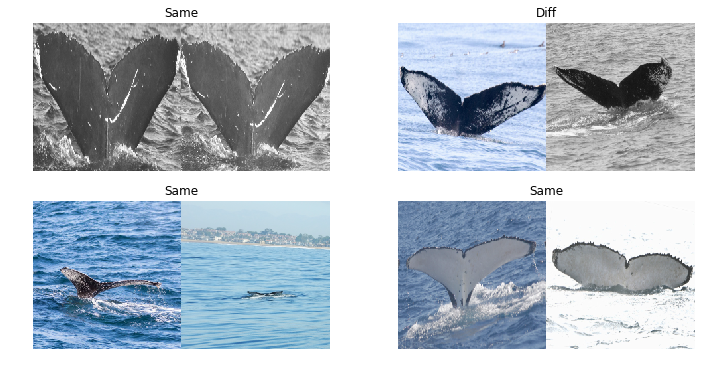

In [15]:
plot_multipair(PairImgDataset(trn, src.train, cls_one), 2, 2)

In [16]:
trn_dl = DataLoader(PairImgDataset(trn, trn, cls_one),
                    batch_size=bs,
                    shuffle=True,
                    num_workers=num_workers)
val_dl = DataLoader(PairImgDataset(val, trn, cls_one),
                    batch_size=bs,
                    shuffle=False,
                    num_workers=num_workers)

data_bunch = ImageDataBunch(trn_dl, val_dl)

In [ ]:
# del trn, val, trn_dl, val_dl  # clean up

In [17]:
def normalize_batch(batch):
    stat_tensors = [torch.tensor(l).cuda() for l in imagenet_stats]
    return [normalize(batch[0][0], *stat_tensors), normalize(batch[0][1], *stat_tensors)], batch[1]

In [18]:
data_bunch.add_tfm(normalize_batch)

In [19]:
class SiameseNetwork(nn.Module):
    def __init__(self, arch=models.resnet18):
        super(SiameseNetwork, self).__init__()
        self.cnn = create_body(arch, pretrained=True)
        nf = fastai.callbacks.hooks.num_features_model(self.cnn) * 2
        self.fc = create_head(nf, 5)
    
    def forward_once(self, x):
        output = self.cnn(x)
        output = self.fc(output)
        return output
    
    def forward(self, img1, img2):
        output1 = self.forward_once(img1)
        output2 = self.forward_once(img2)
        return output1, output2

Contrastive Loss
$$(1-Y)\frac{1}{2}(D_W)^2 + (Y)\frac{1}{2}\{max(0,m-D_W)\}^2$$

$$D_W = \sqrt{\{G_W(X_1)-G_W(X_2)\}^2}$$

$Y$ is the label for same or different image  
$G_W$ is the output of our network for one image  
$D_W$ euclidean distance

In [20]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()  # just super() is fine?
        self.margin = margin
    
    def forward(self, output, label):
        label = label.float()  # convert from tensor long to float
        euclidean_distance = F.pairwise_distance(output[0], output[1])
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

# Training

In [21]:
learn = Learner(data_bunch, SiameseNetwork(), loss_func=ContrastiveLoss())
learn.split([learn.model.cnn[6], learn.model.fc])
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06


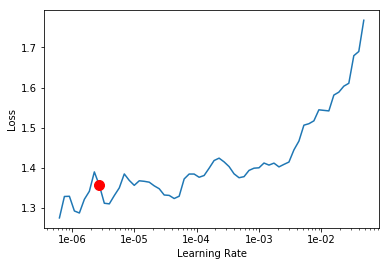

In [22]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit(1)

# Validation

## Validation Plot

TODO: Create a plotting of the result with dissimlariyt value. 

## Validation MAP5

src.train.y.reconstruct(4786)  ## to get class name

TODO:
* Remove single batch restriction
* need to run a for loop for the train and validation set
* refactor everything into a function that can return a list of classes up to 5
    * multiple functions. one that get the features input is model and dataset return tensor ouput [rows, 5 features]  
    * functions that get all pairwise distance
    * function that sort and convert dist to class and add new whale

In [166]:
trn_cls = np.asarray([src.train.y.reconstruct(i).obj for i in learn.data.train_ds.cls[:bs]])  # TODO remove Batch size

In [ ]:
threshold_new_whale = 0.0001  # when to mark new_whale
trn_cls = [src.train.y.reconstruct(i) for i in learn.data.train_ds.cls[:bs]]  # convert class int to class name

In [46]:
learn.model.eval()
trn_features_map = torch.Tensor()
sample = next(iter(learn.data.train_dl))[0][0]  # one batch
with torch.no_grad():
    result = learn.model.forward_once(sample).cpu()
    trn_features_map = torch.cat((trn_features_map, result))

In [108]:
val_sample = next(iter(learn.data.valid_dl))[0][0]
val_features_map = torch.Tensor()
with torch.no_grad():
    result = learn.model.forward_once(val_sample).cpu()
    val_features_map = torch.cat((trn_features_map, result))

In [169]:
val_res_cls = []
for v in val_features_map:
    dist = F.pairwise_distance(v, trn_features_map)
    dist, idx = dist.sort(descending=True)
    cls_name = trn_cls[idx]  # sort class list
    
    res = []
    for v, c in zip(d1_sorted, cls_name):
        if len(res) == 5: break

        if v <= threshold_new_whale:
            # confidence threshold not met 
            res.append('new_whale')
            if len(res) == 5: break
        if c not in res:
            # reconstruct convert class integer to class name
            res.append(c)
    
    val_res_cls.append(res)

In [ ]:
## Backup copy
class PairImgDataset(Dataset):
    def __init__(self, ds, p=0.5):
        """
        Args:
            ds (LabelList): a tuple containing a PIL Image and a Category class
            p (float): probability of returning a same image class sample
        """
        self.ds = ds
        self.cls = ds.y.items  # class's int value
        self.p = p
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        same_cls = np.random.choice([0,1], p=[1-self.p, self.p])  # have control over balancing the split
        return self.same_class(idx) if same_cls else self.diff_class(idx)
    
    def same_class(self, idx):
        img1 = self.ds[idx]  # image + class
        
        if img1[1].obj == 'new_whale' or img1[1].obj in cls_one:
            # new_whale and classes with single image are paired with its augmented self
            img2 = self.ds[idx][0]  # fastai return a new augmented image at each access
        else:
            idx2 = np.where(self.cls[idx] == self.cls)[0]  # idx of images with same class including itself
            np.random.shuffle(idx2)  # randomize idx
            img2 = self.ds[idx2[0]][0]
        return self.combine_img(img1[0], img2, 1)
    
    def diff_class(self, idx):
        img1 = self.ds[idx]
        idxs = self.cls.tolist()
        
        if img1[1].obj != 'new_whale' or img1[1].obj not in cls_one:
            # remove same class images from possible selection
            idxs_same = np.where(self.cls[idx] == self.cls)[0]
            idxs = list(set(idxs) - set(idxs_same))
        
        np.random.shuffle(idxs)
        img2 = self.ds[idxs[0]][0]
        return self.combine_img(img1[0], img2, 0)
        
    def combine_img(self, img1, img2, same_cls):
        # Image does not resize until data is accessed or displayed
        return [Image(img1.data), Image(img2.data)], same_cls